## TIMORIS: Tutorial
This notebook demonstrates the minimal working pipeline for detecting tubule-like structures in spatial transcriptomics data using the TIMORIS tool.

# TIMORIS: Tubule Detection in Spatial Transcriptomics Data

## 1. Introduction

**Biological Question**: How can we detect tubule-like structures in spatial transcriptomics data of mouse testis using only **spatial coordinates** and **geometry** (without predefined gene markers)?

In this tutorial, we will demonstrate the **TIMORIS** tool to identify tubule-like structures in **mouse testis tissue** using spatial transcriptomics data.

---

## 2. Dataset

We will use a **synthetic or real MERFISH** dataset derived from **mouse testis** (with 491 genes and spatial coordinates). The dataset has been processed to contain spatially resolved gene expression and cell locations.

**Dataset URL**: [Spatial Viewer](https://junzlilab-shiny.med.umich.edu/spatialViewer/)

### Key Data Features:
- **Cells**: ~10,000-20,000
- **Genes**: 491 (targeted MERFISH gene panel)
- **Spatial Coordinates**: Cells are spatially positioned on a 2D grid.
- **Metadata**: Includes cell annotations, spatial density, tubule assignments.

---

## 3. Installation

Before running the tutorial, you need to install the **TIMORIS** package. Run the following command to install it locally:

```bash
pip install -e .

## Step 1: Load and Preprocess Data

In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from timoris import (
    preprocess_data,
    estimate_spatial_density,
    sample_empty_centroids,
    cluster_centroids,
    assign_tubule_regions_by_rays,
    refine_tubules
)

In [19]:
# Path to your input file (update as needed)
input_path = "/home/shuzh/TIMORIS/example_data/example_dataset_small.h5ad"
adata = preprocess_data(input_path, file_type='h5ad')
adata

View of AnnData object with n_obs × n_vars = 4512 × 491
    obs: 'label', 'vol', 'p0', 'p1', 'z', 'max_corr', 'ncounts', 'gc_12clust', 'tube', 'ang', 'rad', 'dist_to_edge', 'abin_maxcorr', 'abin_maxcorr_no1', 'good_area', 'sert_abin_maxcorr', 'kmeans12', 'n_genes', 'spatial_density', 'tubule_id'
    var: 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'tubule_id_colors'
    obsm: 'spatial'

In [20]:
adata.obsm['spatial'] = adata.obs[['p1', 'p0']].to_numpy()

/tmp/ipykernel_3187250/720783795.py:1: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm['spatial'] = adata.obs[['p1', 'p0']].to_numpy()


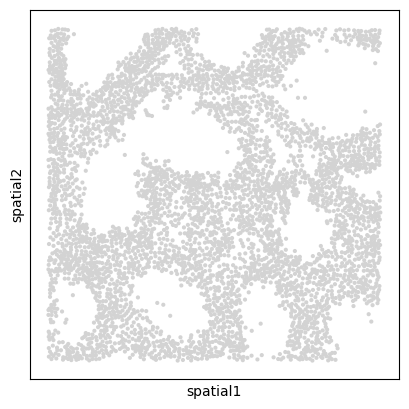

In [21]:
sc.pl.spatial(adata, spot_size = 100)

In [8]:
from sklearn.neighbors import KernelDensity


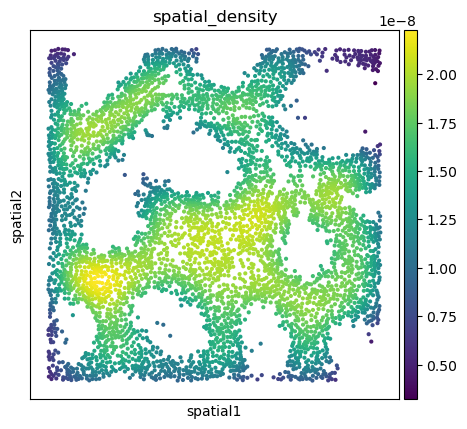

In [9]:
adata = estimate_spatial_density(adata, bandwidth=600)

sc.pl.spatial(adata, color="spatial_density", cmap="viridis", spot_size=100)

## Step 2:  Detecting Centroids in Empty Spaces
Now, we identify the potential centroids (empty spots) in the spatial layout of the tissue.

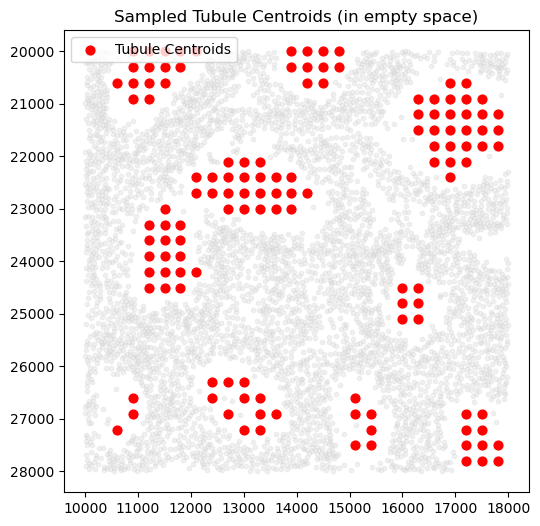

In [10]:
centroids = sample_empty_centroids(adata, grid_size=300, min_distance=200)

# Plot to visualize
plt.figure(figsize=(6, 6))
coords = adata.obsm["spatial"]
plt.scatter(coords[:, 0], coords[:, 1], s=10, color="lightgray", alpha=0.3)
plt.scatter(centroids[:, 0], centroids[:, 1], s=40, color="red", label="Tubule Centroids")
plt.gca().invert_yaxis()
plt.title("Sampled Tubule Centroids (in empty space)")
plt.legend()
plt.show()


### Step 3: Cluster the centroids

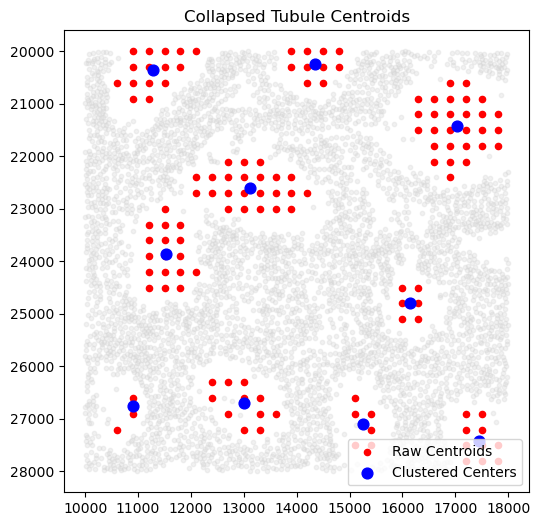

In [11]:
clustered_centroids = cluster_centroids(centroids, eps=300)

# Visualize
plt.figure(figsize=(6, 6))
coords = adata.obsm["spatial"]
plt.scatter(coords[:, 0], coords[:, 1], s=10, color="lightgray", alpha=0.3)
plt.scatter(centroids[:, 0], centroids[:, 1], s=20, color="red", label="Raw Centroids")
plt.scatter(clustered_centroids[:, 0], clustered_centroids[:, 1], s=60, color="blue", label="Clustered Centers")
plt.legend()
plt.gca().invert_yaxis()
plt.title("Collapsed Tubule Centroids")
plt.show()

### Step 4: Grow Spatial Neighborhoods Around Centroids
Next, let’s cluster the centroids and assign tubules based on radial rays from each centroid:

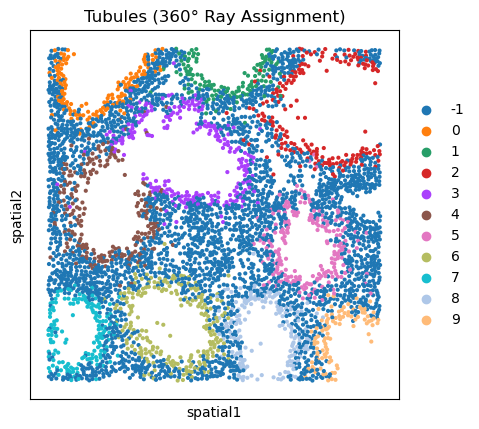

In [12]:
adata = assign_tubule_regions_by_rays(adata, clustered_centroids, n_directions=360, max_distance=3000)
sc.pl.spatial(adata, color="tubule_id", title="Tubules (360° Ray Assignment)", spot_size=100)

### Step 5: Refine the tubules we have found
Finally, we refine the detected tubule regions by removing outliers, filling gaps, and expanding boundaries where necessary.

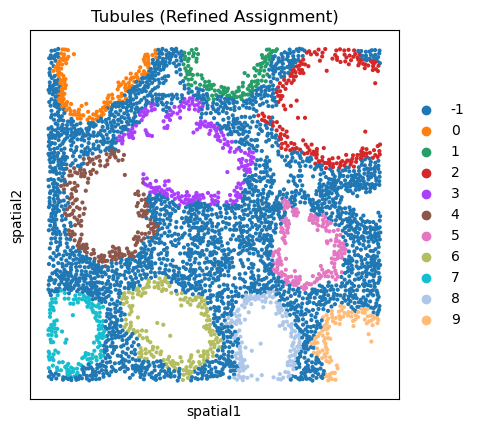

In [13]:
adata = refine_tubules(adata)
sc.pl.spatial(adata, color="tubule_id", title="Tubules (Refined Assignment)", spot_size=100)

10. Answering the Biological Question
Based on the results:

Expected Answer: The tool should successfully detect tubule-like regions, even without relying on specific gene markers. We expect clear regions with high spatial coherence that match the anatomical features of seminiferous tubules in testis.

Conclusion: This demonstrates the ability of TIMORIS to detect tubule-like structures purely based on spatial geometry in spatial transcriptomics data.

